In [2]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn.model_selection import train_test_split #разделение выборки
from sklearn import preprocessing #предобработка
%matplotlib inline
plt.style.use('seaborn')

In [3]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


отток клиентов в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии

In [4]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [5]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


In [6]:
# Проверим, что в наших данных нет пропусков:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

 расширим наш датасет с помощью методов Feature Engineering. Создадим следующие признаки:

BalanceSalaryRatio — отношение баланса на счетах к заработной плате клиента;
TenureByAge — отношение времени пользования банком к возрасту клиента;
CreditScoreGivenAge — отношение кредитного рейтинга к возрасту клиента.

In [7]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure']/(churn_data['Age'])
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/(churn_data['Age'])

Также перекодируем единственный текстовый категориальный признак Gender в бинарный столбец (1 — 'Male', 0 — 'Female'):

In [8]:
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


In [9]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

In [10]:
# позаботимся о масштабах признаков. Проведём нормализацию матрицы наблюдений X:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, посмотрим на сбалансированность данных. Для этого воспользуемся методом value_counts() и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [11]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

In [12]:
# для стратифицированного разбиения - параметр stratify
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


In [13]:
# Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:
print('Train :', y_train.value_counts(normalize=True))
print('\n')
print('Test :', y_test.value_counts(normalize=True))

Train : 0    0.675704
1    0.324296
Name: Exited, dtype: float64


Test : 0    0.675159
1    0.324841
Name: Exited, dtype: float64


-----

Задание 4.2
Обучите модель логистической регрессии на тренировочных данных. Используйте в качестве алгоритма минимизации функции потерь (параметр solver) стохастический градиентный спуск. В качестве значения параметра random_state возьмите 42 для воспроизводимости результатов. Остальные параметры оставьте по умолчанию.

Предскажите метки классов для тренировочной и тестовой выборок.

Чему равно значение целевой метрики на тренировочной и тестовой выборках? Ответ приведите с точностью до двух знаков после точки-разделителя.

In [14]:
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train)
#Вывод отчет о метриках классификации
print('Тренировочная:', round(metrics.f1_score(y_train, y_train_pred), 2))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test)
#Вывод отчет о метриках классификации
print('Тестовая:', round(metrics.f1_score(y_test, y_test_pred), 2))

Тренировочная: 0.49
Тестовая: 0.47


Задание 4.3
Сгенерируйте полиномиальные признаки степени 3 для тренировочной и тестовой выборок. Используйте класс PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Чему равно количество признаков в тренировочной выборке?

In [15]:
# создаем генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train)

X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

print(X_train_poly.shape[1])

454


Задание 4.4
Обучите модель логистической регрессии на полиномиальных признаках.

Используйте в качестве алгоритма минимизации функции потерь (параметр solver) стохастический градиентный спуск. Параметру random_state выставите значение 42 для воспроизводимости результатов. Увеличьте максимальное количество итераций, выделяемых на сходимость (параметр max_iter), до 1000.

Остальные параметры оставьте по умолчанию.

Предскажите метки классов для тренировочной и тестовой выборок.

Чему равно значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках? Ответ приведите с точностью до двух знаков после точки-разделителя.

In [16]:
log_reg_poly = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg_poly.fit(X_train_poly, y_train)

#Делаем предсказание для тренировочной выборки
y_train_poly_pred = log_reg_poly.predict(X_train_poly)
# Делаем предсказание для тестовой выборки
y_test_poly_pred = log_reg_poly.predict(X_test_poly)

#Вывод отчет о метриках классификации
print('Тренировочная:', round(metrics.f1_score(y_train, y_train_poly_pred), 2))
#Вывод отчет о метриках классификации
print('Тестовая:', round(metrics.f1_score(y_test, y_test_poly_pred), 2))

Тренировочная: 0.66
Тестовая: 0.64


Задание 4.5
Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. Используйте логистическую регрессию, обученную на полиномиальных признаках из предыдущего задания.

В качестве порога вероятности используйте значения из следующего диапазона:

thresholds = np.arange(0.1, 1, 0.05)
Напомним алгоритм, как определить оптимальный порог вероятности:

Предсказать вероятности оттока для каждого клиента из тестовой выборки.
В цикле перебирать значения порогов вероятности threshold: сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0. Далее рассчитать метрику и занести её в заранее созданный список.
Постройте график зависимости целевой метрики от порога вероятности.

Какому порогу вероятности соответствует наибольшее значение целевой метрики? Ответ приведите с точностью до двух знаков после точки-разделителя.

ОТВЕТ: 0.35

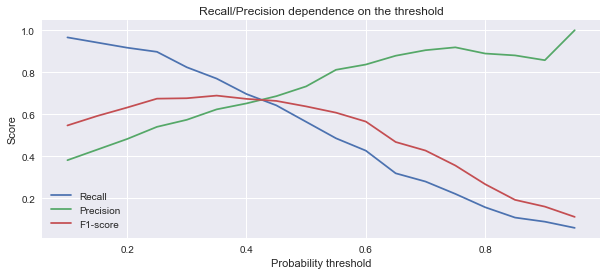

In [17]:
#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = log_reg_poly.predict_proba(X_test_poly)[:, 1]
#Для удобства завернём numpy-массив в Pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold, относим к классу 1
    #В противном случае — к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))
    
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
 
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend()

Задание 4.6
Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Чему равно значение целевой метрики на тестовой выборке? Ответ приведите с точностью до двух знаков после точки-разделителя.

In [18]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.35

y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(round(metrics.f1_score(y_test, y_test_pred_opt), 2))

0.69


---

# Задание 7.1
Обучите на обучающей выборке дерево решений с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона. Минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

Сделайте предсказания для тренировочной и тестовой выборок.

Чему равно значение целевой метрики на каждой из выборок? Ответ округлите до двух знаков после точки-разделителя.

In [19]:
from sklearn import tree

#Создаём объект класса DecisionTreeClassifier
dt = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности 
    max_depth=8, # максимальная глубина
    min_samples_leaf=10,
    random_state=42 #генератор случайных чисел
)
dt.fit(X_train, y_train) # обучение

y_dt_pred_train = dt.predict(X_train) # предсказания
y_dt_pred_test = dt.predict(X_test)

print('Тренировочная выборка:', round(metrics.f1_score(y_train, y_dt_pred_train), 2))
print('Тестовая выборка:', round(metrics.f1_score(y_test, y_dt_pred_test), 2))

Тренировочная выборка: 0.72
Тестовая выборка: 0.64


# Задание 7.2
Постройте случайный лес из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона. Минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

Сделайте предсказания для тренировочной и тестовой выборок.

Чему равно значение целевой метрики на каждой из выборок? Ответ округлите до двух знаков после точки-разделителя.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?
ОТВЕТ: смогли

In [20]:
from sklearn import ensemble

rf = ensemble.RandomForestClassifier(
    n_estimators=500, 
    criterion='entropy', 
    max_depth=8, 
    min_samples_leaf=10, 
    random_state=42 
)

rf.fit(X_train, y_train)
 
y_rf_pred_train = rf.predict(X_train)
y_rf_pred_test = rf.predict(X_test)

print('Тренировочная выборка:', round(metrics.f1_score(y_train, y_rf_pred_train), 2))
print('Тестовая выборка:', round(metrics.f1_score(y_test, y_rf_pred_test), 2))

Тренировочная выборка: 0.74
Тестовая выборка: 0.66


# Задание 7.4
Финальные штрихи

Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. Используйте модель, которая показала наилучшее качество.

В качестве порога вероятности используйте значения из следующего диапазона:

thresholds = np.arange(0.1, 1, 0.05)
Напомним, как определить оптимальный порог вероятности:

Предсказать вероятности оттока для каждого клиента из тестовой выборки.
В цикле перебирать значения порогов вероятности threshold.
Сделать предсказание класса по принципу: если вероятность  threshold, отнести объект к классу 1, в противном случае — к классу 0.
Рассчитать метрику и занести её в заранее созданный список.
Постройте график зависимости целевой метрики от порога вероятности.

Какому порогу вероятности соответствует наибольшее значение целевой метрики? Ответ округлите до двух знаков после точки-разделителя.

c:\Users\mors0\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mors0\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


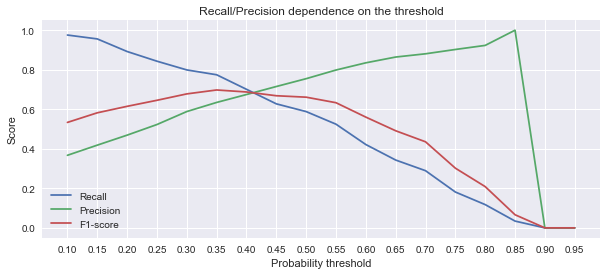

In [21]:
#Считаем оттока для каждого клиента из тестовой выборки
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = rf.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность оттока > threshold относим к классу 1
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.set_xticks(thresholds)
ax.legend()

# Задание 7.5
Сделайте предсказание на тестовой выборке с подобранным порогом вероятности. Используйте модель, показавшую наилучшее качество.

Чему равно значение целевой метрики на тестовой выборке? Ответ округлите до двух знаков после точки-разделителя.

In [27]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.35

y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрику
print(round(metrics.f1_score(y_test, y_test_pred_opt), 2))

0.7
